# A. Exploratory Data Analysis

<img src='https://i2.wp.com/hubmapconsortium.org/wp-content/uploads/2020/11/imageofweek.png?w=1200&ssl=1'>
<h1><center>HuBMAP: Hacking the Kidney - EDA</center><h1>
    
# 1. <a id='Introduction'>Introduction</a>

###  1.1 What is HuBMAP?
The [Human BioMolecular Atlas Program](https://hubmapconsortium.org/what-is-hubmap/) is a major endeavour working to catalyze the development of a framework for mapping the human body at single cell resolution.

In [1]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/yCh4XnD7rEE" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

###  1.2 What is HuBMAP:Hacking the Kidney Competition?
- This compeition starts by mapping the human kidney at single cell resolution. We will detect the [functional tissue units](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4126067/)(FTU) accross different tissue preparation pipelines.By this we will implement a successful and robust glomeruli FTU detector.
- We also have the opportunity to present our findings to a panel of judges of this competition for additional consideration


### 1.3 What is FTU?
- An [FTU](https://pubmed.ncbi.nlm.nih.gov/24103658/) is defined as a “three-dimensional block of cells centered around a capillary, such that each cell in this block is within diffusion distance from any other cell in the same block”

### 1.4 What do we need to do?
- We will develop segmentation algorithms that identify glomeruli in the PAS stained microscopy data. Yes, external data is allowed and/or pre-trained machine learning models in support of FTU segmentation.
- The leaderboard of this competition is calculated with approximately 42% of the test data.The final results will be based on the other 58%, so the final standings may be different.

### 1.5 Metric: Dice Coefficient.

![](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

- Image Credits: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
- The evaluation metric of this competition is Dice Coefficient. 
The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:
  
<center>   $\Large  \frac{2*|X ∩ Y|}{|X|+|Y|}$   </center>

where X is the predicted set of pixels and Y is the ground truth.

- Dice coefficient, is a statistical tool which measures the similarity between two sets of data. This index has become arguably the most broadly used tool in the validation of image segmentation algorithms created with AI, but it is a much more general concept which can be applied sets of data for a variety of applications including NLP.
- Read more about it on the [Evaluation Page](https://www.kaggle.com/c/hubmap-kidney-segmentation/overview/supervised-ml-evaluation)

### 1.6 Relation between Dice Coefficient and Jaccard Score.

<center>   $\Large  D   =   \frac{2*|X ∩ Y|}{|X|+|Y|}$   </center>
<br>
<center>   $\Large  J =      \frac{|X ∩ Y|}{|X|+|Y|-|X ∩ Y|}$   </center>
<br>
<center>   $\Large  D = \frac{2J}{J+1}$   </center>
<br>
<center>   $\Large  J = \frac{D}{2-D}$   </center>

# 2. <a id='importing'>Importing the necessary libraries📗</a> 

In [2]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import json
%matplotlib inline
import shapely.geometry as sg
import shapely.ops as so
import zipfile
import cv2

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#seaborn
import seaborn as sns

#color
from colorama import Fore, Back, Style

#networkx
import networkx as nx

import seaborn as sns
sns.set(style="whitegrid")

#tifffile
from PIL import Image
import tifffile as tiff
import cv2
from tqdm.notebook import tqdm
import zipfile

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

     |████████████████████████████████| 64 kB 905 kB/s eta 0:00:011


# 3. <a id='reading'>Reading the train.csv 📚</a>

In [3]:
# List files available
list(os.listdir("../input/hubmap-kidney-segmentation"))

['train',
 'sample_submission.csv',
 'train.csv',
 'test',
 'HuBMAP-20-dataset_information.csv']

In [4]:
IMAGE_PATH = "../input/hubmap-kidney-segmentation/"

train_df = pd.read_csv('../input/hubmap-kidney-segmentation/train.csv')
hubmap_df = pd.read_csv('../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv')
test_df = pd.read_csv('../input/hubmap-kidney-segmentation/sample_submission.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,train_df.shape)
print(Fore.YELLOW + 'HubMap data shape: ',Style.RESET_ALL,hubmap_df.shape)
print(Fore.YELLOW + 'Test data shape: ',Style.RESET_ALL,test_df.shape)

train_df.head(5)

Training data shape:   (8, 2)
HubMap data shape:   (13, 16)
Test data shape:   (5, 2)


id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...

In [5]:
hubmap_df.head(5)

image_file  width_pixels  height_pixels  \
0  afa5e8098.tiff         43780          36800   
1  54f2eec69.tiff         22240          30440   
2  1e2425f28.tiff         32220          26780   
3  e79de561c.tiff         27020          16180   
4  c68fe75ea.tiff         19780          26840   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
0   afa5e8098-anatomical-structure.json               afa5e8098.json   
1   54f2eec69-anatomical-structure.json               54f2eec69.json   
2   1e2425f28-anatomical-structure.json               1e2425f28.json   
3   e79de561c-anatomical-structure.json               e79de561c.json   
4   c68fe75ea-anatomical-structure.json               c68fe75ea.json   

   patient_number                       race               ethnicity     sex  \
0           67347                      White  Not Hispanic or Latino  Female   
1           67548  Black or African American  Not Hispanic or Latino    Male   
2           63921                      White  Not Hispanic or Latino    Male   
3           67026  Black or African American  Not Hispanic or Latino    Male   
4           67112                      White  Not Hispanic or Latino    Male   

   age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
0   58              59.0               160.0        23.0      Right   
1   58              79.9               190.5        22.0      Right   
2   48             131.5               193.0        35.3      Right   
3   53              73.0               166.0        26.5       Left   
4   56              91.2               167.6        32.5       Left   

   percent_cortex  percent_medulla  
0              55               45  
1              75               25  
2              65               35  
3              55               45  
4              80               20

In [6]:
hubmap_df.groupby(['race']).count()['sex'].to_frame()

sex
race                          
Black or African American    4
White                        9

# 4.<a id='basic'>Basic Data Exploration 🏕️</a> 

## General Information

In [7]:
# Null values and Data types
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(train_df.info())
print('-------------')
print(Fore.BLUE + 'Test Set !!',Style.RESET_ALL)
print(test_df.info())
print('-------------')
print(Fore.GREEN + 'HuBMAP Set !!',Style.RESET_ALL)
print(hubmap_df.info())

Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8 non-null      object
 1   encoding  8 non-null      object
dtypes: object(2)
memory usage: 256.0+ bytes
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5 non-null      object 
 1   predicted  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 208.0+ bytes
None
-------------
HuBMAP Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   image_file                             13 non-null     object 

### Missing values

In [8]:
hubmap_df.isna().sum()

image_file                               0
width_pixels                             0
height_pixels                            0
anatomical_structures_segmention_file    0
glomerulus_segmentation_file             0
patient_number                           0
race                                     0
ethnicity                                0
sex                                      0
age                                      0
weight_kilograms                         1
height_centimeters                       1
bmi_kg/m^2                               1
laterality                               0
percent_cortex                           0
percent_medulla                          0
dtype: int64

In [9]:
train_df.isna().sum()

id          0
encoding    0
dtype: int64

There are 3 missing values in hubmap_df and no missing values in train_df

In [10]:
! ls ../input/hubmap-kidney-segmentation/train/

0486052bb-anatomical-structure.json  54f2eec69-anatomical-structure.json
0486052bb.json			     54f2eec69.json
0486052bb.tiff			     54f2eec69.tiff
095bf7a1f-anatomical-structure.json  aaa6a05cc-anatomical-structure.json
095bf7a1f.json			     aaa6a05cc.json
095bf7a1f.tiff			     aaa6a05cc.tiff
1e2425f28-anatomical-structure.json  cb2d976f4-anatomical-structure.json
1e2425f28.json			     cb2d976f4.json
1e2425f28.tiff			     cb2d976f4.tiff
2f6ecfcdf-anatomical-structure.json  e79de561c-anatomical-structure.json
2f6ecfcdf.json			     e79de561c.json
2f6ecfcdf.tiff			     e79de561c.tiff


In [11]:
# Total number of Patient in the dataset(train+test)

print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['id'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,test_df['id'].count())

Total Patients in Train set:   8
Total Patients in Test set:   5


`5` : Patients in Test Set

## Unique Patients(Ids)

In [12]:
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{train_df['id'].count()},", Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{train_df['id'].value_counts().shape[0]}.")

The total patient ids are  8, from those the unique ids are  8.


In [13]:
train_patient_ids = set(train_df['id'].unique())
test_patient_ids = set(test_df['id'].unique())

train_patient_ids.intersection(test_patient_ids)

set()

We see `none` patients in test set that can be found in train set.

In [14]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['id', 'encoding']


### Patient Counts

In [15]:
train_df['id'].value_counts().max()

1

In [16]:
test_df['id'].value_counts().max()

1

In train and test sets, we can see one Patient and it mean Patient id is unique

## Number of Patients and Files in Training Images Folder

In [17]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/train"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        folder_names.add(filenames[j][:9])
    folders = len(folder_names)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'patients/ids')

24  files, 8  patients/ids


In [18]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/test"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        folder_names.add(filenames[j][:9])
    folders = len(folder_names)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'patients/ids')

10  files, 5  patients/ids


## JSON FILES COUNT

In [19]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/train"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json':
            folder_names.add(filenames[j][:9])
    folders = len(folder_names)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{folders:,}',Style.RESET_ALL," json-files")

8   json-files


In [20]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/test"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json':
            folder_names.add(filenames[j][:9])
    folders = len(folder_names)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{folders:,}',Style.RESET_ALL," json-files")

5   json-files


## Reading Normal json files

In [21]:
files = 0
path = "../input/hubmap-kidney-segmentation/train"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json' and len(filenames[j])<15:
            df = pd.read_json(f'../input/hubmap-kidney-segmentation/train/{filenames[j]}')
            print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

96  rows and 4   columns in the aaa6a05cc json file
201  rows and 4   columns in the e79de561c json file
350  rows and 4   columns in the 095bf7a1f json file
182  rows and 4   columns in the 1e2425f28 json file
165  rows and 4   columns in the 2f6ecfcdf json file
126  rows and 4   columns in the 0486052bb json file
322  rows and 4   columns in the cb2d976f4 json file
143  rows and 4   columns in the 54f2eec69 json file


We can see that there are no normal json files in the test set.

In [22]:
files = 0
path = "../input/hubmap-kidney-segmentation"
i = 0

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    if i==0:
        i += 1
        files += len(filenames)
        for j in range(files):
            if filenames[j][-4:]=='json' and len(filenames[j])<15:
                df = pd.read_json(f'../input/hubmap-kidney-segmentation/{filenames[j]}')
                print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

## Reading anatomical-structure json files

In [23]:
files = 0
path = "../input/hubmap-kidney-segmentation/train"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json' and len(filenames[j])>15:
            df = pd.read_json(f'../input/hubmap-kidney-segmentation/train/{filenames[j]}')
            print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

2  rows and 4   columns in the 2f6ecfcdf-anatomical-structure json file
1  rows and 4   columns in the 095bf7a1f-anatomical-structure json file
2  rows and 4   columns in the 1e2425f28-anatomical-structure json file
3  rows and 4   columns in the cb2d976f4-anatomical-structure json file
2  rows and 4   columns in the 0486052bb-anatomical-structure json file
2  rows and 4   columns in the aaa6a05cc-anatomical-structure json file
1  rows and 4   columns in the e79de561c-anatomical-structure json file
2  rows and 4   columns in the 54f2eec69-anatomical-structure json file


In [24]:
files = 0
path = "../input/hubmap-kidney-segmentation/test"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json' and len(filenames[j])>15:
            df = pd.read_json(f'../input/hubmap-kidney-segmentation/test/{filenames[j]}')
            print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

4  rows and 4   columns in the 26dc41664-anatomical-structure json file
3  rows and 4   columns in the b2dc8411c-anatomical-structure json file
2  rows and 4   columns in the b9a3865fc-anatomical-structure json file
2  rows and 4   columns in the c68fe75ea-anatomical-structure json file
4  rows and 4   columns in the afa5e8098-anatomical-structure json file


In [25]:
files = 0
path = "../input/hubmap-kidney-segmentation"
i = 0

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    if i==0:
        i += 1
        files += len(filenames)
        for j in range(files):
            if filenames[j][-4:]=='json' and len(filenames[j])>15:
                df = pd.read_json(f'../input/hubmap-kidney-segmentation/{filenames[j]}')
                print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

In [26]:
train_df.head()

id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...

We see some encoding column over there. This encoding column is RLE-encoded representation of the mask for the objects in the image.

## What is this RLE Encoding?

[Run-length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) (RLE) is a form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. This is most useful on data that contains many such runs. Consider, for example, simple graphic images such as icons, line drawings, Conway's Game of Life, and animations. It is not useful with files that don't have many runs as it could greatly increase the file size. 

## Sample code for RLE Encoding

In [27]:
# Perform Run Length Encoding (RLE) data compression algorithm on string
def encode(s):

    encoding = "" 
    i = 0
    while i < len(s):
        # count occurrences of character at index i
        count = 1

        while i + 1 < len(s) and s[i] == s[i + 1]:
            count = count + 1
            i = i + 1
        encoding += str(count) + s[i]
        i = i + 1

    return encoding
s = "ABBCCCD"
print(encode(s))


1A2B3C1D


## Advantages and Disadvantages Of RLE:

This [algorithm](https://www.prepressure.com/library/compression-algorithm/rle) is very easy to implement and does not require much CPU horsepower. RLE compression is only efficient with files that contain lots of repetitive data. These can be text files if they contain lots of spaces for indenting but line-art images that contain large white or black areas are far more suitable. Computer-generated color images (e.g. architectural drawings) can also give fair compression ratios. And this is used to compress Tiff and Pdf files.

# 5. <a id='details'>Data Exploration in Details 🎠</a>

Getting the columns in hubmap_df

In [28]:
hubmap_df["split"] = "test"
hubmap_df.loc[hubmap_df["image_file"].isin(os.listdir(os.path.join(IMAGE_PATH, "train"))), "split"] = "train"

In [29]:
hubmap_df.columns

Index(['image_file', 'width_pixels', 'height_pixels',
       'anatomical_structures_segmention_file', 'glomerulus_segmentation_file',
       'patient_number', 'race', 'ethnicity', 'sex', 'age', 'weight_kilograms',
       'height_centimeters', 'bmi_kg/m^2', 'laterality', 'percent_cortex',
       'percent_medulla', 'split'],
      dtype='object')

## Parallel Category Diagram

In [30]:
parallel_diagram = hubmap_df[['patient_number','age','sex','race','percent_cortex']]
fig = px.parallel_categories(parallel_diagram, color_continuous_scale=px.colors.sequential.Inferno)
fig.update_layout(title='Parallel category diagram 1 on hubmap set')
fig.show()

In [31]:
parallel_diagram = hubmap_df[['patient_number','age','sex','race','percent_medulla']]
fig = px.parallel_categories(parallel_diagram, color_continuous_scale=px.colors.sequential.Inferno)
fig.update_layout(title='Parallel category diagram 2 on hubmap set')
fig.show()

In [32]:
def dist(df,column,color):
    sns.distplot(df[column],label=column,color=color)
    plt.legend()

## Exploring the 'race' columns

In [33]:
hubmap_df[['race','split']].value_counts()

race                       split
White                      train    5
                           test     4
Black or African American  train    3
                           test     1
dtype: int64

In [34]:
hubmap_df[['race','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='blue',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the race column in the HuBMAP-20 Set')

In [35]:
df = hubmap_df.groupby(['race','split'])['race'].count().reset_index(name = 'counts')
df['race_split'] = df['race']+'_'+df['split']
fig = px.pie(df, values='counts', names='race_split', title='Patient Race Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

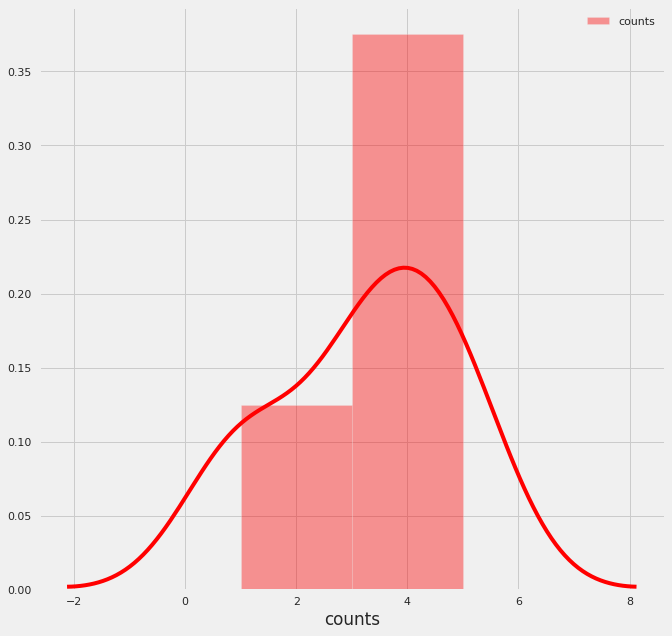

In [36]:
df = hubmap_df.groupby(['race','split'])['race'].count().reset_index(name = 'counts')
plt.figure(figsize=(10,10))
dist(df,"counts","red")

`9` : White - `5` : Train, `4` : Test

`4` : Black or African American  `3` : Train, `1` : Test

### Network Graph

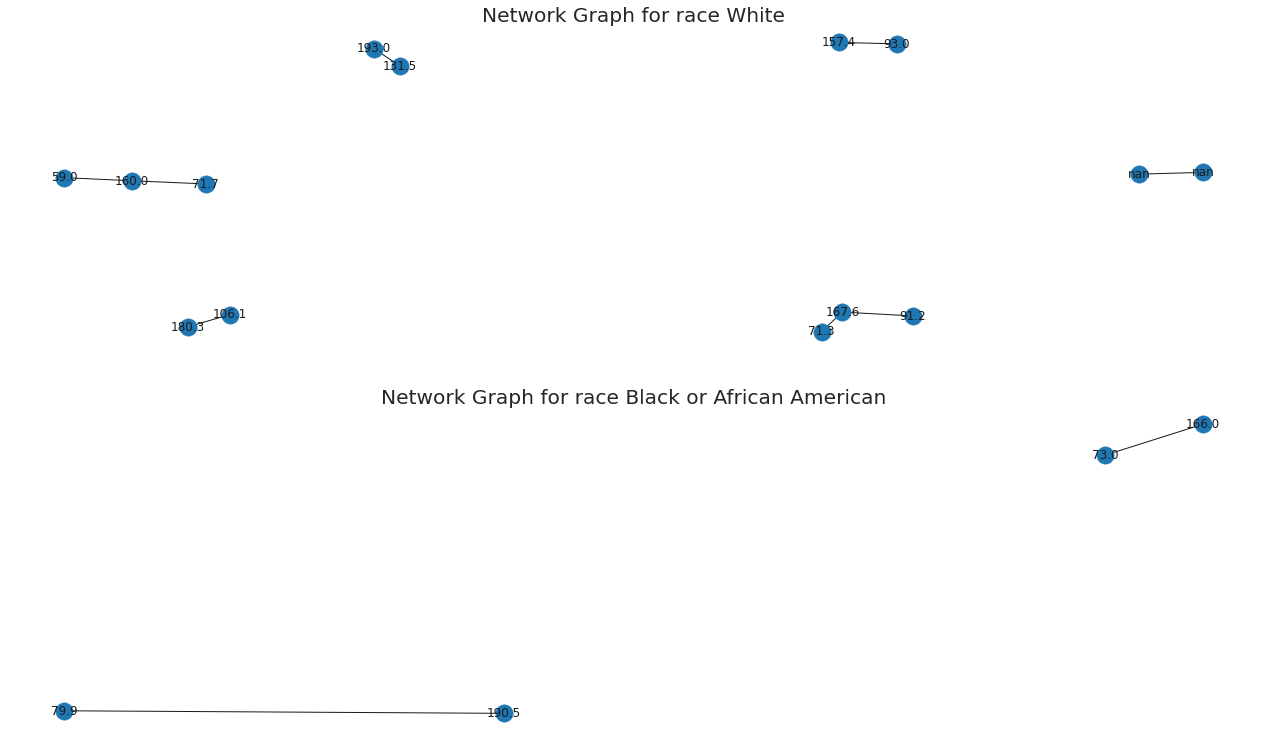

In [37]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(hubmap_df['race'].unique()):
    hubmap_df_type = hubmap_df.loc[hubmap_df['race'] == t]
    bad_weight = list(hubmap_df_type['weight_kilograms'].value_counts(normalize=True)[hubmap_df_type['weight_kilograms'].value_counts(normalize=True) < 0.01].index)
    bad_height = list(hubmap_df_type['height_centimeters'].value_counts(normalize=True)[hubmap_df_type['height_centimeters'].value_counts(normalize=True) < 0.01].index)
    bad_mes = list(set(bad_weight + bad_height))
    hubmap_df_type = hubmap_df_type.loc[(hubmap_df_type['weight_kilograms'].isin(bad_weight) == False) & (hubmap_df_type['height_centimeters'].isin(bad_height) == False)]
    G = nx.from_pandas_edgelist(hubmap_df_type, 'weight_kilograms', 'height_centimeters', ['bmi_kg/m^2'])
    plt.subplot(2, 1, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Network Graph for race {t}')

## Exploring the Patient Number Columns

In [38]:
hubmap_df[['patient_number','split']].value_counts()

patient_number  split
67548           train    2
67347           test     2
68555           train    1
68304           test     1
68250           train    1
67177           train    1
67112           test     1
67026           train    1
                test     1
65631           train    1
63921           train    1
dtype: int64

In [39]:
hubmap_df[['patient_number','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='red',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the patient_number column in the HuBMAP-20 Set')

In [40]:
df = hubmap_df.groupby(['patient_number','split'])['patient_number'].count().reset_index(name = 'counts')
df['patient_number_split'] = df['patient_number'].astype('str')+'_'+df['split']
fig = px.pie(df, values='counts', names='patient_number_split', title='Patient Number Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

### Network Graph

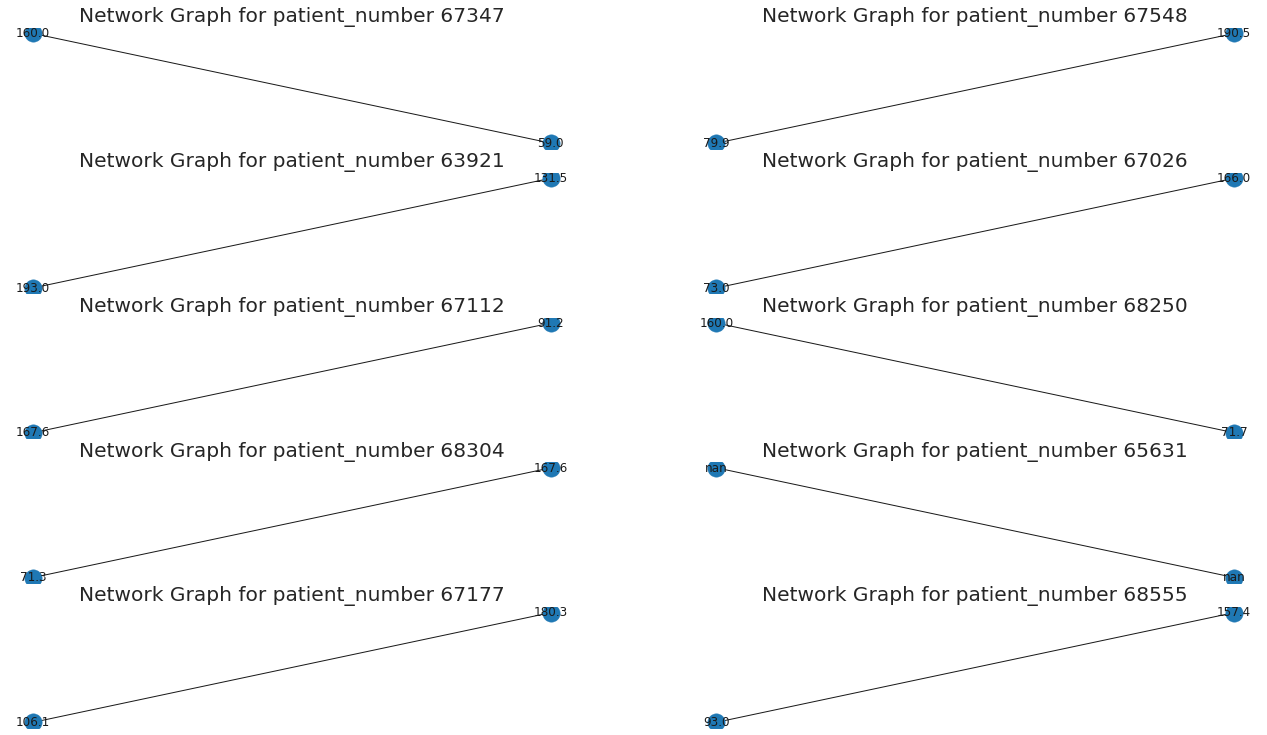

In [41]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(hubmap_df['patient_number'].unique()):
    hubmap_df_type = hubmap_df.loc[hubmap_df['patient_number'] == t]
    bad_weight = list(hubmap_df_type['weight_kilograms'].value_counts(normalize=True)[hubmap_df_type['weight_kilograms'].value_counts(normalize=True) < 0.01].index)
    bad_height = list(hubmap_df_type['height_centimeters'].value_counts(normalize=True)[hubmap_df_type['height_centimeters'].value_counts(normalize=True) < 0.01].index)
    bad_mes = list(set(bad_weight + bad_height))
    hubmap_df_type = hubmap_df_type.loc[(hubmap_df_type['weight_kilograms'].isin(bad_weight) == False) & (hubmap_df_type['height_centimeters'].isin(bad_height) == False)]
    G = nx.from_pandas_edgelist(hubmap_df_type, 'weight_kilograms', 'height_centimeters', ['bmi_kg/m^2'])
    plt.subplot(5, 2, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Network Graph for patient_number {t}')

## Exploring the Ethinicity Column

In [42]:
hubmap_df[['ethnicity','split']].value_counts()

ethnicity               split
Not Hispanic or Latino  train    8
                        test     5
dtype: int64

In [43]:
hubmap_df[['ethnicity','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='green',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Ethnicity column in the HuBMAP-20 Set')

In [44]:
df = hubmap_df.groupby(['ethnicity','split'])['ethnicity'].count().reset_index(name = 'counts')
df['ethnicity_split'] = df['ethnicity']+'_'+df['split']
fig = px.pie(df, values='counts', names='ethnicity_split', title='Patient Ethnicity Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Exploring the sex columns

In [45]:
hubmap_df[['sex','split']].value_counts()

sex     split
Male    train    5
Female  train    3
        test     3
Male    test     2
dtype: int64

In [46]:
hubmap_df[['sex','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='yellow',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Sex column in the HuBMAP-20 Set')

In [47]:
df = hubmap_df.groupby(['sex','split'])['sex'].count().reset_index(name = 'counts')
df['sex_split'] = df['sex']+'_'+df['split']
fig = px.pie(df, values='counts', names='sex_split', title='Patient Gender Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Exploring the age columns

In [48]:
hubmap_df[['age','split']].value_counts()

age  split
58   train    2
     test     2
76   train    1
73   train    1
66   test     1
56   test     1
53   train    1
     test     1
48   train    1
44   train    1
31   train    1
dtype: int64

In [49]:
hubmap_df[['age','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='orange',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Age column in the HuBMAP-20 Set')

In [50]:
df = hubmap_df.groupby(['age','split'])['age'].count().reset_index(name = 'counts')
df['age_split'] = df['age'].astype('str')+'_'+df['split']
fig = px.pie(df, values='counts', names='age_split', title='Patient Ages Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Exploring the Laterality Column

In [51]:
hubmap_df[['laterality','split']].value_counts()

laterality  split
Right       train    5
Left        train    3
            test     3
Right       test     2
dtype: int64

In [52]:
hubmap_df[['laterality','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='purple',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Laterality column in the HuBMAP-20 Set')

In [53]:
df = hubmap_df.groupby(['laterality','split'])['laterality'].count().reset_index(name = 'counts')
df['laterality_split'] = df['laterality']+'_'+df['split']
fig = px.pie(df, values='counts', names='laterality_split', title='Patient Laterality Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Exploring the Percent Medulla Column

In [54]:
hubmap_df[['percent_medulla','split']].value_counts()

percent_medulla  split
45               test     4
25               train    3
35               train    2
20               train    2
45               train    1
20               test     1
dtype: int64

In [55]:
hubmap_df[['percent_medulla','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='pink',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Medulla column in the HuBMAP-20 Set')

In [56]:
df = hubmap_df.groupby(['percent_medulla','split'])['percent_medulla'].count().reset_index(name = 'counts')
df['percent_medulla_split'] = df['percent_medulla'].astype('str')+'_'+df['split']
fig = px.pie(df, values='counts', names='percent_medulla_split', title='Patient Percent_Medulla Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Exploring the Percent Cortex column

In [57]:
hubmap_df[['percent_cortex','split']].value_counts()

percent_cortex  split
55              test     4
75              train    3
80              train    2
65              train    2
80              test     1
55              train    1
dtype: int64

In [58]:
hubmap_df[['percent_cortex','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='cyan',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Medulla column in the HuBMAP-20 Set')

In [59]:
df = hubmap_df.groupby(['percent_cortex','split'])['percent_cortex'].count().reset_index(name = 'counts')
df['percent_cortex_split'] = df['percent_cortex'].astype('str')+'_'+df['split']
fig = px.pie(df, values='counts', names='percent_cortex_split', title='Patient Percent_Cortex Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Distribution Of Age Over Race

In [60]:
df = hubmap_df
fig = px.violin(df, y='age', x='race', box=True, color='sex', points="all",
               hover_data=hubmap_df.columns)
fig.show()

Text(0.5, 1.0, 'Distribution of Ages')

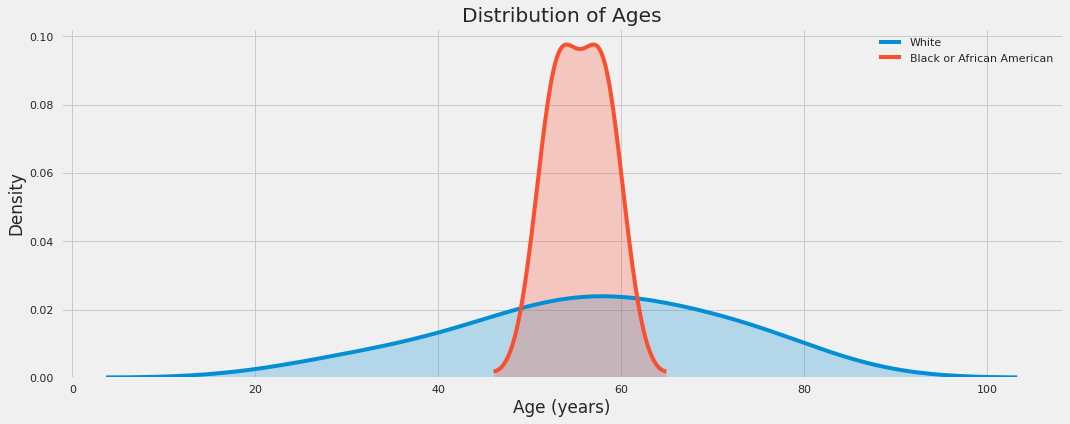

In [61]:
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['race'] == 'White', 'age'], label = 'White',shade=True)
sns.kdeplot(df.loc[df['race'] == 'Black or African American', 'age'], label = 'Black or African American',shade=True)


# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

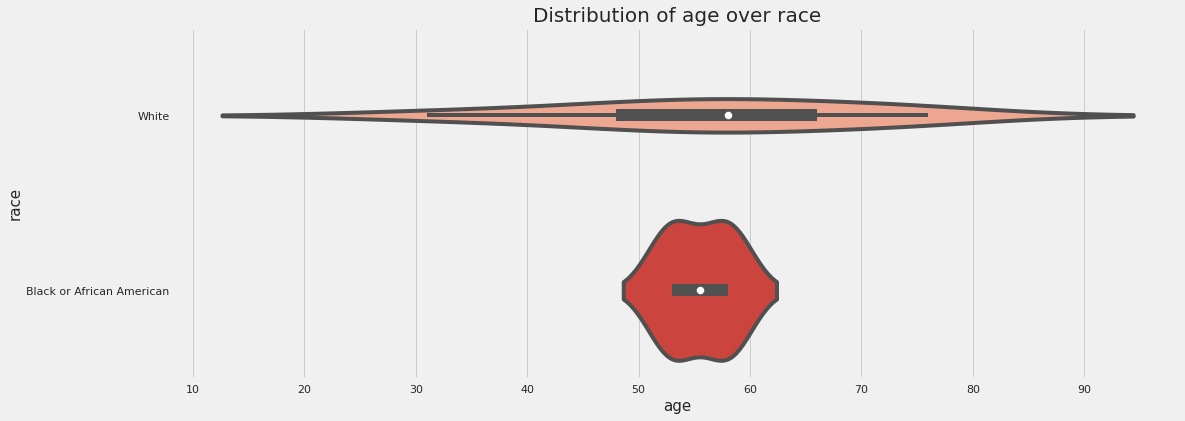

In [62]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = df['age'], y = df['race'], palette = 'Reds')
ax.set_xlabel(xlabel = 'age', fontsize = 15)
ax.set_ylabel(ylabel = 'race', fontsize = 15)
ax.set_title(label = 'Distribution of age over race', fontsize = 20)
plt.show()

In [63]:
df = hubmap_df.groupby(['age','race'])['age'].count().reset_index(name = 'counts')
df['age_race'] = df['age'].astype('str')+'_'+df['race']
fig = px.pie(df, values='counts', names='age_race', title='Distribution Of Age Over Race')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Distribution of race over Medulla

In [64]:
df = hubmap_df
fig = px.violin(df, x='race', y='percent_medulla', box=True, color='sex', points="all",
               hover_data=hubmap_df.columns)
fig.show()

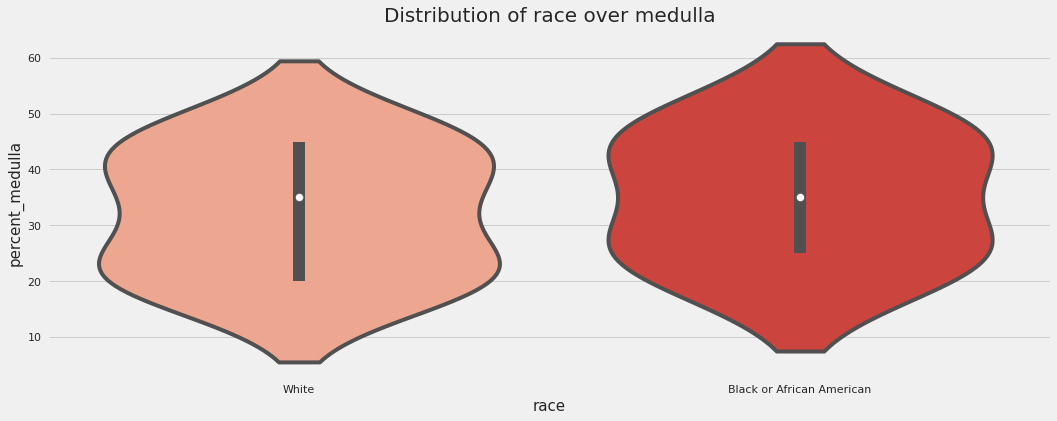

In [65]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = df['race'], y = df['percent_medulla'], palette = 'Reds')
ax.set_xlabel(xlabel = 'race', fontsize = 15)
ax.set_ylabel(ylabel = 'percent_medulla', fontsize = 15)
ax.set_title(label = 'Distribution of race over medulla', fontsize = 20)
plt.show()

In [66]:
df = hubmap_df.groupby(['race','percent_medulla'])['race'].count().reset_index(name = 'counts')
df['race_percent_medulla'] = df['race']+'_'+df['percent_medulla'].astype('str')
fig = px.pie(df, values='counts', names='race_percent_medulla', title='Distribution Of Race Over Percent Medulla')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Distiribution of age over percent medulla

Text(0.5, 1.0, 'Distribution of Ages')

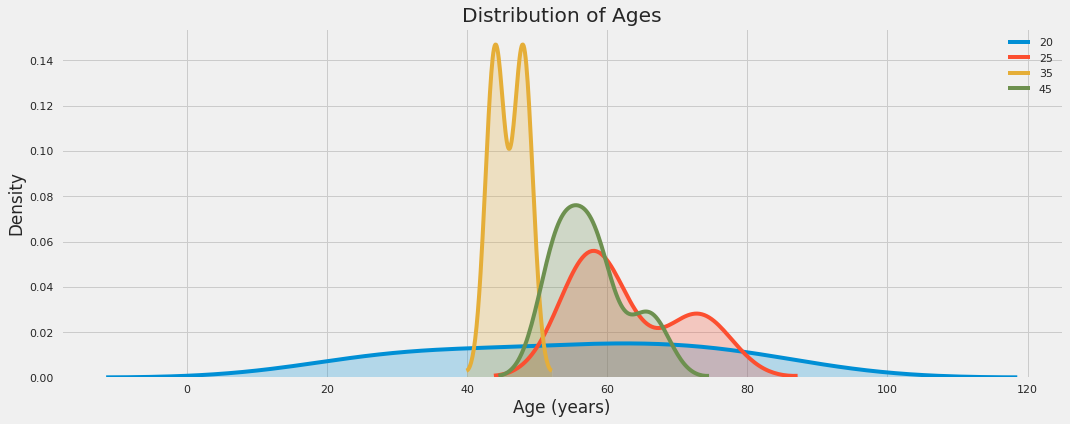

In [67]:
df = hubmap_df
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['percent_medulla'] == 20, 'age'], label = 20,shade=True)
sns.kdeplot(df.loc[df['percent_medulla'] == 25, 'age'], label = 25,shade=True)
sns.kdeplot(df.loc[df['percent_medulla'] == 35, 'age'], label = 35,shade=True)
sns.kdeplot(df.loc[df['percent_medulla'] == 45, 'age'], label = 45,shade=True)


# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

In [68]:
df = hubmap_df.groupby(['age','percent_medulla'])['age'].count().reset_index(name = 'counts')
df['age_percent_medulla'] = df['age'].astype('str')+'_'+df['percent_medulla'].astype('str')
fig = px.pie(df, values='counts', names='age_percent_medulla', title='Distribution Of Age Over Percent Medulla')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Distribution of age over percent cortex

Text(0.5, 1.0, 'Distribution of Ages')

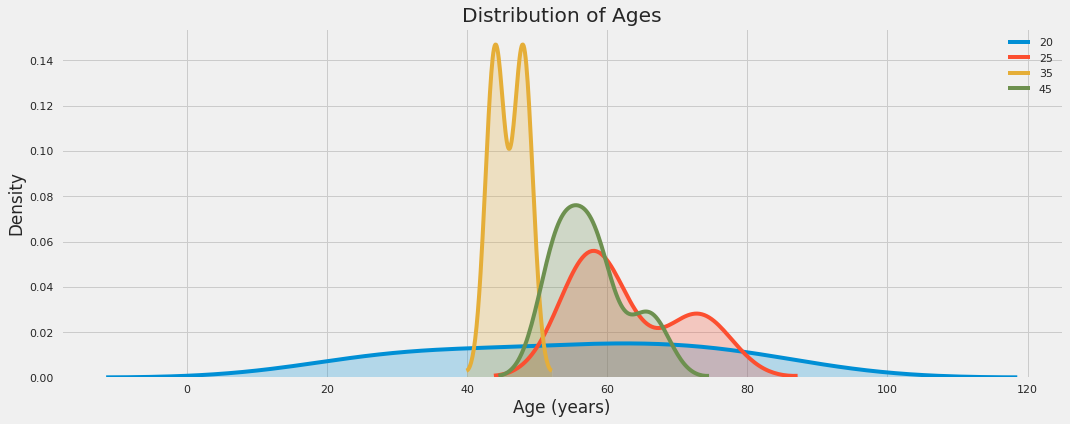

In [69]:
df = hubmap_df
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['percent_cortex'] == 80, 'age'], label = 20,shade=True)
sns.kdeplot(df.loc[df['percent_cortex'] == 75, 'age'], label = 25,shade=True)
sns.kdeplot(df.loc[df['percent_cortex'] == 65, 'age'], label = 35,shade=True)
sns.kdeplot(df.loc[df['percent_cortex'] == 55, 'age'], label = 45,shade=True)


# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

In [70]:
df = hubmap_df.groupby(['age','percent_cortex'])['age'].count().reset_index(name = 'counts')
df['age_percent_cortex'] = df['age'].astype('str')+'_'+df['percent_cortex'].astype('str')
fig = px.pie(df, values='counts', names='age_percent_cortex', title='Distribution Of Age Over Percent Cortex')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

From the above graphs we infer that the sum of percent medulla and percent cortex is 100. Let's verify it below.

In [71]:
(hubmap_df['percent_medulla']+hubmap_df['percent_cortex']).unique()

array([100])

## Sex vs Race

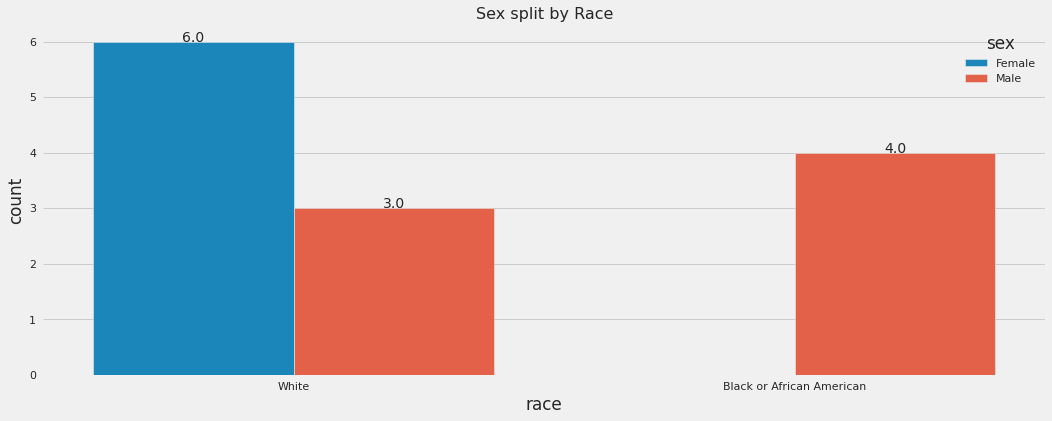

In [72]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=hubmap_df, x='race', hue='sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Sex split by Race', fontsize=16)
sns.despine(left=True, bottom=True)

In [73]:
fig = px.box(hubmap_df, x="sex", y="age", points="all")
fig.show()

In [74]:
df = hubmap_df.groupby(['sex','race'])['sex'].count().reset_index(name = 'counts')
df['sex_race'] = df['sex'].astype('str')+'_'+df['race'].astype('str')
fig = px.pie(df, values='counts', names='sex_race', title='Sex Versus Race')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

From the above graphs we can infer that there is no female black in the test set.

## HeatMap for hubmap

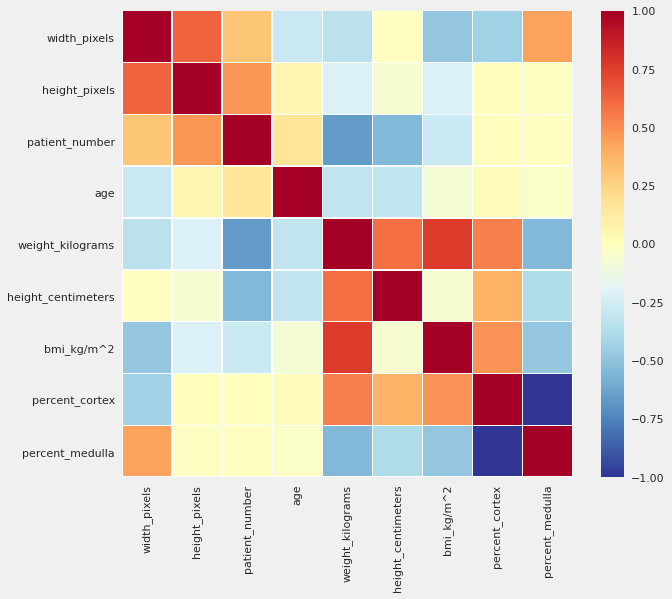

In [75]:
corrmat = hubmap_df.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap = 'RdYlBu_r', linewidths = 0.5)

# 6. <a id='visual'>Visualising Images : Tiff 🗺️</a>  

In [76]:
print(Fore.YELLOW + 'Train .tiff number of images:',Style.RESET_ALL, len(list(os.listdir('../input/hubmap-kidney-segmentation/train')))/3, '\n' +
      Fore.BLUE + 'Test .tiff number of images:',Style.RESET_ALL, len(list(os.listdir('../input/hubmap-kidney-segmentation/test')))/2)

Train .tiff number of images:  8.0 
Test .tiff number of images:  5.0


In [77]:
IMAGE_PATH = '../input/hubmap-kidney-segmentation'
os.path.join(IMAGE_PATH, 'train/095bf7a1f.tiff')

'../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff'

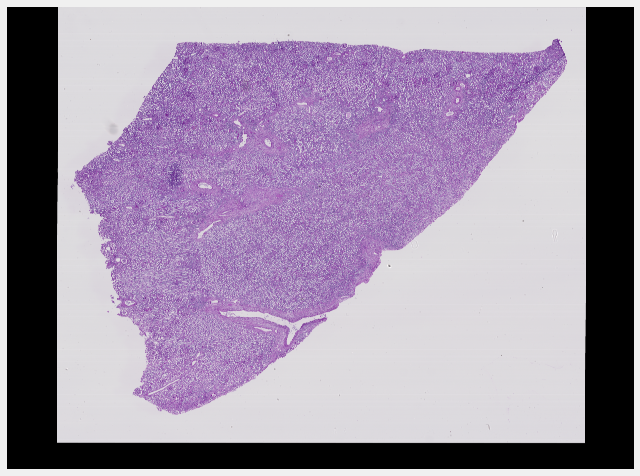

In [78]:
im = tiff.imread(
    os.path.join(IMAGE_PATH, "train/0486052bb.tiff")
)
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.axis("off")
del im

Credit goes to https://www.kaggle.com/iafoss/256x256-images/data


mean: [0.68666217 0.57685694 0.71148024] , std: [0.21855879 0.28083339 0.20806194]


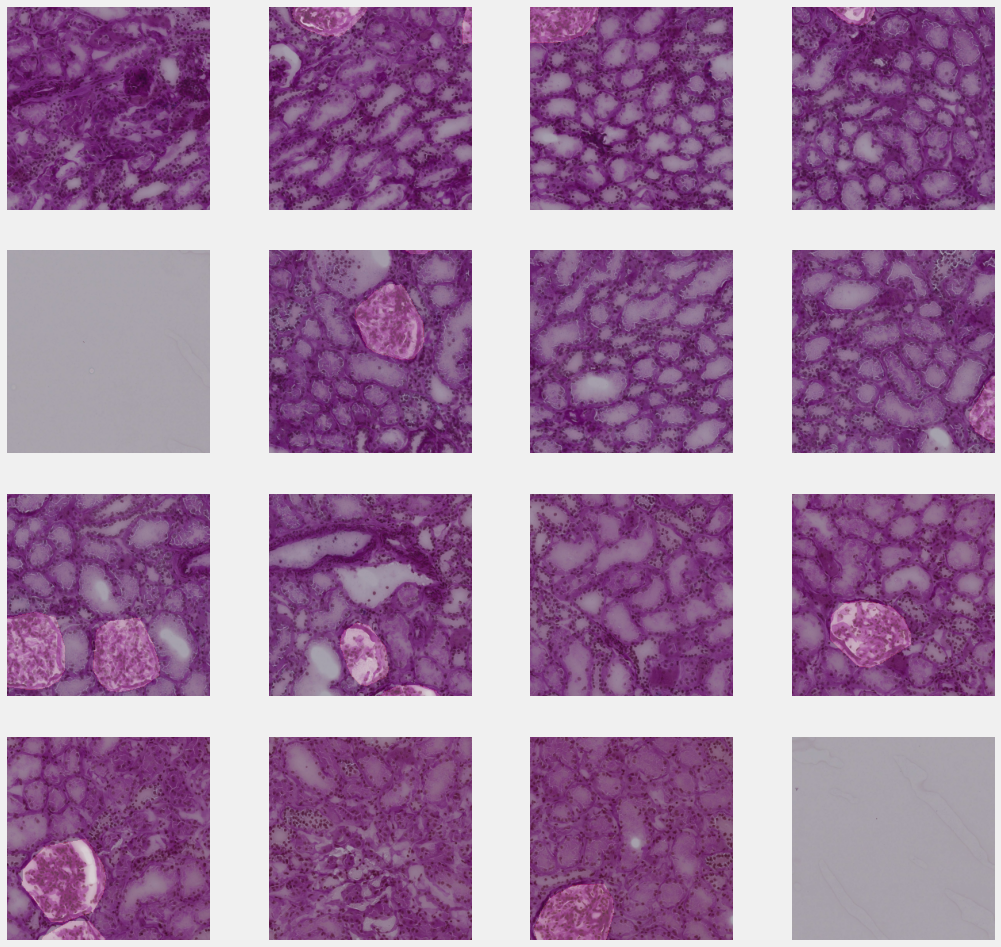

In [79]:
sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times 
MASKS = '../input/hubmap-kidney-segmentation/train.csv'
DATA = '../input/hubmap-kidney-segmentation/train/'
OUT_TRAIN = 'train.zip'
OUT_MASKS = 'masks.zip'
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, shape, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs
df_masks = pd.read_csv(MASKS).set_index('id')
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5:img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        #add padding to make the image dividable into tiles
        shape = img.shape
        pad0,pad1 = (reduce*sz - shape[0]%(reduce*sz))%(reduce*sz), (reduce*sz - shape[1]%(reduce*sz))%(reduce*sz)
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],constant_values=0)
        mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],constant_values=0)

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,(img.shape[0]//reduce,img.shape[1]//reduce),interpolation = cv2.INTER_AREA)
        img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
        img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

        mask = cv2.resize(mask,(mask.shape[0]//reduce,mask.shape[1]//reduce),interpolation = cv2.INTER_NEAREST)
        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)

        #write data
        for i,(im,m) in enumerate(zip(img,mask)):
            if im.sum() == 0: continue
            
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{i}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{i}.png', m)

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)
columns, rows = 4,4
idx0 = 870
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            flags = cv2.IMREAD_COLOR
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), np.uint8), flags)
            flags = cv2.IMREAD_GRAYSCALE
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), np.uint8), flags)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

# 8. <a id= 'json_images'>Plot polygon from JSON Files</a>

Credits : https://www.kaggle.com/subbuvolvosekar/plot-ploygon-from-json-using-shapely

In [80]:
TRAIN_PATH = '/kaggle/input/hubmap-kidney-segmentation/train/'

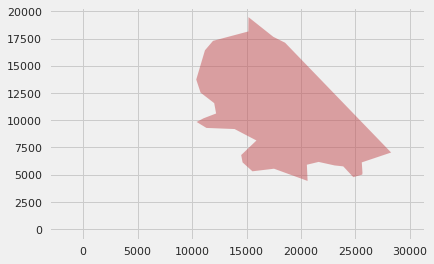

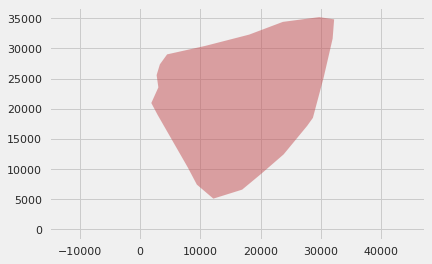

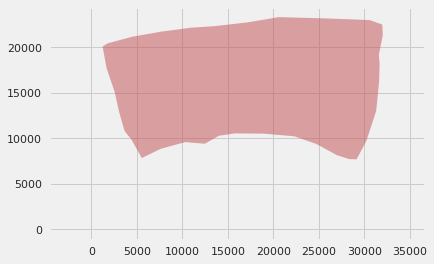

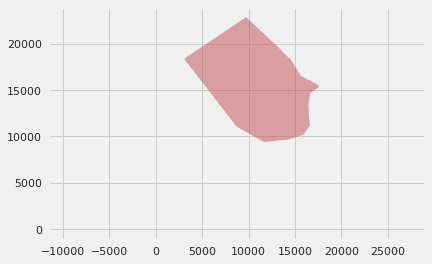

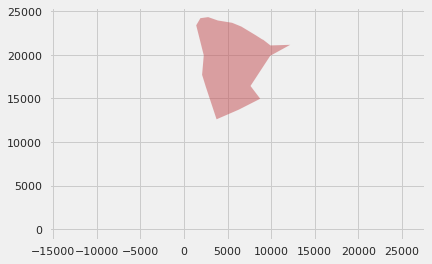

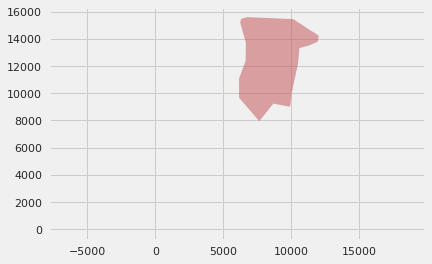

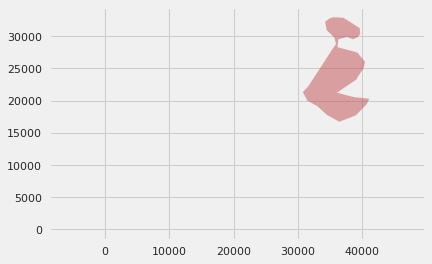

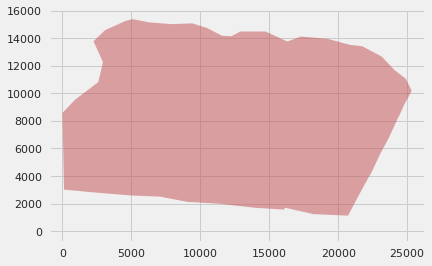

In [81]:
file = sorted(os.listdir(TRAIN_PATH))
for i in range(0,len(file),3):
    with open(TRAIN_PATH+file[i]) as f:
        data = json.load(f)

    r1 = sg.Polygon([tuple(i) for i in data[0]['geometry']['coordinates'][0]])
    r2 = sg.box(0.5,0.5,1.5,1.5)
    r3 = sg.box(4,4,5,5)

    new_shape = so.cascaded_union([r1, r2, r3])
    fig, axs = plt.subplots()
    axs.set_aspect('equal', 'datalim')

    for geom in new_shape.geoms:    
        xs, ys = geom.exterior.xy    
        axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

    plt.show()

# 9. <a id='pandas_profiling'>Pandas Profiling 🌤️</a>

In [82]:
profile_hubmap_df = pdp.ProfileReport(hubmap_df)

In [83]:
profile_hubmap_df

# B.Modelling

We are using **pytorch** implementation of **UNet** Model implemented in **https://github.com/qubvel/segmentation_models.pytorch** and this is getting installed offline.

In [84]:
!mkdir -p /tmp/pip/cache/
!cp ../input/segmentationmodelspytorch/segmentation_models/efficientnet_pytorch-0.6.3.xyz /tmp/pip/cache/efficientnet_pytorch-0.6.3.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/pretrainedmodels-0.7.4.xyz /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/segmentation-models-pytorch-0.1.2.xyz /tmp/pip/cache/segmentation_models_pytorch-0.1.2.tar.gz
!cp ../input/segmentationmodelspytorch/segmentation_models/timm-0.1.20-py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodelspytorch/segmentation_models/timm-0.2.1-py3-none-any.whl /tmp/pip/cache/
!pip install --no-index --find-links /tmp/pip/cache/ efficientnet-pytorch
!pip install --no-index --find-links /tmp/pip/cache/ segmentation-models-pytorch

Looking in links: /tmp/pip/cache/
Processing /tmp/pip/cache/efficientnet_pytorch-0.6.3.tar.gz
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=76ed6518cc9f290f19c790b5ea2531717498fb0b7388b5a685bd81b128a6448b
  Stored in directory: /root/.cache/pip/wheels/13/61/ce/bb0a5a0cbdc953125d9e5eac180085769c9298201dcb8f81b4
Successfully built efficientnet-pytorch
Looking in links: /tmp/pip/cache/
Processing /tmp/pip/cache/segmentation_models_pytorch-0.1.2.tar.gz
Processing /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
Processing /tmp/pip/cache/timm-0.2.1-py3-none-any.whl
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.2-py3-none-any.whl size=53937 sha256=7f18ea9cf8c15676c4df8c8412c1258a868df80981db08b4776fa5f5c75aa796
  Stored in directory: /root/.cache/pip/wheels/bb/77/6c/05a8ed505fef2924a75661b15743398af4d8f08b6ac9357e01
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-p

## Necessary Imports

In [85]:
from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torchvision
import cv2
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.ndimage.interpolation import zoom
import albumentations as A
from torch.nn import functional as F

import time
import random
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch.unet import Unet

In [86]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b1-f1951068.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b2-8bb594d6.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b3-5fb5a3c3.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b4-6ed6700e.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b5-b6417697.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b6-c76e70fd.pth /root/.cache/torch/hub/checkpoints/
!cp ../input/efficientnet-pytorch-b0-b7/efficientnet-b7-dcc49843.pth /root/.cache/torch/hub/checkpoints/

In [87]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything(42)

## Dataset

In [88]:
class HuBMAPDataset(Dataset):
    def __init__(self, ids, phase):
        self.ids = ids
        if phase=='train':
            self.transform = get_train_transform()
        else:
            self.transform = get_val_transform()
        
    def __getitem__(self, idx):
        name = self.ids[idx]
        img = cv2.imread(f"../input/256256-hubmap/train/{name}").astype("float32")
        img /= 255.
        mask = cv2.imread(f"../input/256256-hubmap/masks/{name}")[:,:,0:1]

        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        img = img.transpose(2,0,1).astype('float32')
        mask = mask.transpose(2,0,1).astype('float32')
        return img, mask

    def __len__(self):
        return len(self.ids)

    
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(),
            A.OneOf([
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.3),
            A.OneOf([
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                A.GridDistortion(),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            A.ShiftScaleRotate(p=0.2),
            A.Resize(256,256,always_apply=True),
    ],p=1.)

def get_val_transform():
    return A.Compose([
        A.Resize(256,256,always_apply=True),
    ],p=1.)

## DataLoader

In [89]:
directory_list = os.listdir('../input/256256-hubmap/train')
dir_df = pd.DataFrame(directory_list, columns=['Image_Paths'])
dir_df

Image_Paths
0      54f2eec69_415.png
1      095bf7a1f_290.png
2     cb2d976f4_1138.png
3      095bf7a1f_494.png
4      095bf7a1f_128.png
...                  ...
5982  cb2d976f4_1416.png
5983     54f2eec69_8.png
5984  095bf7a1f_1091.png
5985    aaa6a05cc_82.png
5986   095bf7a1f_983.png

[5987 rows x 1 columns]

In [90]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df.loc[~df.Folds.isin(fold), "Image_Paths"].values
    val_ids = df.loc[df.Folds.isin(fold), "Image_Paths"].values
    train_ds = HuBMAPDataset(train_ids, "train")
    val_ds = HuBMAPDataset(val_ids, "val")
    train_loader = DataLoader(train_ds, batch_size=16, pin_memory=True, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=4, pin_memory=True, shuffle=False, num_workers=4)
    return train_loader, val_loader

## Model

In [91]:
class HuBMAP(nn.Module):
    def __init__(self):
        super(HuBMAP, self).__init__()
        self.cnn_model = Unet('efficientnet-b5', encoder_weights="imagenet", classes=1, activation=None)
        #self.cnn_model.decoder.blocks.append(self.cnn_model.decoder.blocks[-1])
        #self.cnn_model.decoder.blocks[-2] = self.cnn_model.decoder.blocks[-3]
    
    def forward(self, imgs):
        img_segs = self.cnn_model(imgs)
        return img_segs

## Loss Function

<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/80f87a71d3a616a0939f5360cec24d702d2593a2'>

In [92]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
    
    
class DiceBCELoss(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

## Train Function

In [93]:
def HuBMAPLoss(images, targets, model, device):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    criterion = DiceBCELoss()
    loss = criterion(outputs, targets)
    return loss, outputs

In [94]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    for step, (images, targets) in enumerate(trainloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        loss = loss.detach().item()
        total_loss += loss
        if ((step+1)%10==0 or (step+1)==len(trainloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
                    f'loss: {total_loss/len(trainloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
                )

            
        
def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    for step, (images, targets) in enumerate(validloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss = loss.detach().item()
        total_loss += loss
        if ((step+1)%4==0 or (step+1)==len(validloader)):
            scheduler.step(total_loss/len(validloader))
        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(validloader)}, ' + \
                    f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )

## Creating Folds Column

In [95]:
FOLDS = 5
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    dir_df.loc[val_idx, 'Folds'] = fold

## The Real Training

In [ ]:
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    if fold>1:
        break
    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HuBMAP().to(device)
    optimizer = Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)
    #num_epochs = 15
    num_epochs = 2
    for epoch in range(num_epochs):
        train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        with torch.no_grad():
            valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
    torch.save(model.state_dict(),f'FOLD-{fold}-model.pth')

Since my gpu got exhausted I have trained on cpu for only 1 epoch. I will modify the notebook again when my gpu gets fileed up and write the inference function too. Thanks for reading my kernel.